# GTEX PLIER exploratory analyses

Marc Subirana-Granés (2024)

Pathway Level Information ExtractoR (PLIER) (Mao, et al. bioRxiv. 2017.) is a framework that explicitly aligns latent variables (LVs) with prior knowledge in the form of (often curated) gene sets. Comparisons of PLIER to other methods (e.g., sparse PCA) and other evaluations can be found in the PLIER preprint.

We’re going to explore the GTEx dataset and the corresponding PLIER model. 

## Settings and paths

In [9]:
INPUT_PLIER_MODEL_FILE = NULL 

## Load libraries and data

In [10]:
library(PLIER)
library(ggplot2)
library(assertthat)

source(here::here('scripts/plier_util.R'))
INPUT_PLIER_MODEL_FILE='output/gtex/gtex_plier.rds'

In [11]:
assert_that(!is.null(INPUT_PLIER_MODEL_FILE), msg = "Input PLIER model was not specified")

[1] TRUE

In [12]:
gtex_plier_results=readRDS(here::here(INPUT_PLIER_MODEL_FILE))
num_lvs <- nrow(gtex_plier_results$B)
matrixU <- gtex_plier_results$U
matrixZ <- gtex_plier_results$Z
matrixB <- gtex_plier_results$B

[1] 1042

## Matrix U (gene sets x LVs)

In [13]:
head(matrixU)

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,⋯,LV1033,LV1034,LV1035,LV1036,LV1037,LV1038,LV1039,LV1040,LV1041,LV1042
IRIS_Bcell-Memory_IgG_IgA,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_Bcell-Memory_IgM,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_Bcell-naive,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-N0,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-Th1-restimulated12hour,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-Th1-restimulated48hour,0,0,0,0.1697034,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


If the prior information coefficient matrix, U, has a low number of positive entries for each LV, biological interpretation should be more straightforward. This is one of the constraints in the PLIER model.

### All LVs
For each latent variable (i.e., not just those significantly associated with prior information), how many of the pathways/genesets have a positive entry?

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.001592 0.004571 0.006369 0.047771 

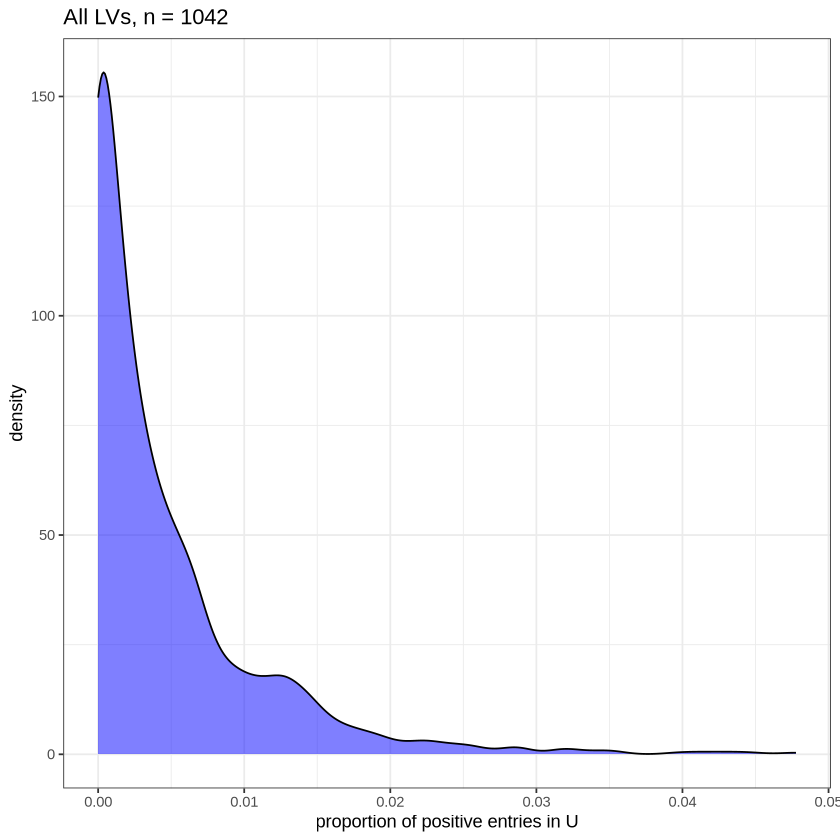

In [18]:
num_lvs <- nrow(matrixB)

u_sparsity_all <- CalculateUSparsity(plier.results = gtex_plier_results,
                                     significant.only = FALSE)
ggplot2::ggplot(as.data.frame(u_sparsity_all),
                ggplot2::aes(x = u_sparsity_all)) +
  ggplot2::geom_density(fill = "blue", alpha = 0.5) +
  ggplot2::theme_bw() +
  ggplot2::labs(x = "proportion of positive entries in U") +
  ggplot2::ggtitle(paste("All LVs, n =", num_lvs))

In [20]:
summary(u_sparsity_all)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.001592 0.004571 0.006369 0.047771 

### Significant pathways, only
What proportion of entries in the U matrix for each LV are significantly associated with that LV?

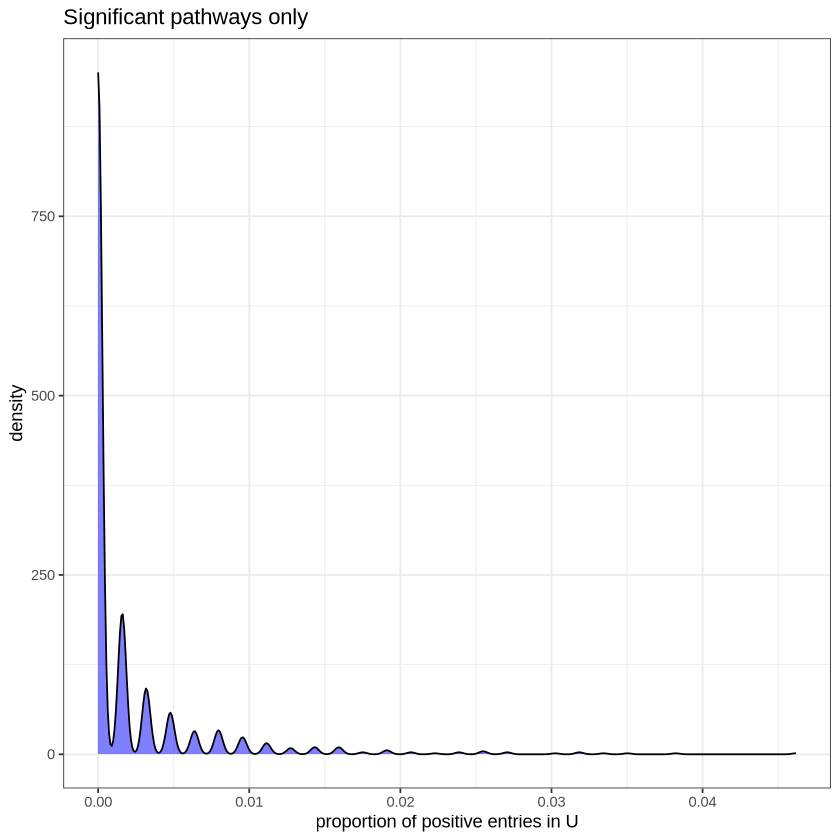

In [21]:
u_sparsity_sig <- CalculateUSparsity(gtex_plier_results, 
                                     significant.only = TRUE,
                                     fdr.cutoff = 0.05)
ggplot2::ggplot(as.data.frame(u_sparsity_sig),
                ggplot2::aes(x = u_sparsity_sig)) +
  ggplot2::geom_density(fill = "blue", alpha = 0.5) +
  ggplot2::theme_bw() +
  ggplot2::labs(x = "proportion of positive entries in U") +
  ggplot2::ggtitle("Significant pathways only")

In [22]:
summary(u_sparsity_sig)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.002051 0.001592 0.046178 

### Pathway coverage
<!-- We’re interested in how the LVs output from PLIER are related to the genesets input to PLIER. -->

In [26]:
coverage_results <- GetPathwayCoverage(plier.results = gtex_plier_results)

What proportion of the pathways input into PLIER are significantly associated (FDR cutoff = 0.05) with LVs?

In [28]:
round(coverage_results$pathway, 3)

[1] 0.519

What proportion of the PLIER LVs have a gene set associated with them?

In [32]:
round(coverage_results$lv, 3)

[1] 0.349

## Reconstruction of gene expression data

### All LVs
We reconstruct gene expression data from the gene loadings and LVs.

In [ ]:
# reconstructed GTEx expression data from PLIER model
recount_recon <- GetReconstructedExprs(z.matrix = as.matrix(matrixZ),
                                       b.matrix = as.matrix(matrixB))
# write reconstructed expression to results
recon.mat.file <- file.path(results.dir, 
                            "recount2_recount2_model_recon_exprs.RDS")
saveRDS(recount.recon, file = recon.mat.file)
# input expression data from intermediate file
recount.input.exprs <- recount.list$rpkm.cm

## Matrix Z (loadings; genes x LVs)

In [18]:
head(matrixZ)

GAS6,0.20762129,0.00000000,0.0000000,0.00000000,0.0000000,0.02653939,0.00000000,0.00000000,0.62387382,0.18440284,⋯,0.0000000,0.00000000,0.1552670,0.00000000,0.00000000,0.03676118,0,0.03729953,0.01813663,0.32003652
MMP14,0.09893808,0.00000000,0.0000000,0.03620340,0.0000000,0.00000000,0.00000000,0.00000000,0.57073574,0.00000000,⋯,0.0000000,0.02603330,0.0000000,0.01795993,0.02515933,0.00000000,0,0.00000000,0.13488302,0.32878006
MARCKSL1,0.00000000,0.00000000,0.0689154,0.00000000,0.0000000,0.06473675,0.00000000,0.00000000,0.06586991,0.04277300,⋯,0.1104464,0.00000000,0.0000000,0.00000000,0.00000000,0.00000000,0,0.00000000,0.00000000,0.07458389
SPARC,0.00000000,0.00000000,0.0000000,0.08840532,0.0000000,0.00000000,0.00000000,0.03131448,0.20514237,0.45000462,⋯,0.0000000,0.00000000,0.1168224,0.00000000,0.03407571,0.13301524,0,0.01732749,0.00000000,0.00000000
CTSD,0.00000000,0.09038044,0.3689761,0.05409820,0.1073371,0.00000000,0.00000000,0.09150932,1.38866053,0.02098779,⋯,0.0000000,0.02845362,0.2228255,0.00000000,0.00000000,0.00000000,0,0.00000000,0.04607547,0.54812303
EPAS1,0.01069210,0.00000000,0.0000000,0.00000000,0.0000000,0.04134291,0.03603086,0.00000000,0.11679199,0.11713569,⋯,0.0000000,0.00000000,0.0000000,0.00000000,0.37824176,0.00000000,0,0.00000000,0.28356290,0.14947889


## Matrix U - AUC


### All LVs

In [16]:
num_lvs

[1] 1042

In [18]:
head(gtex_plier_results$U)

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,⋯,LV1033,LV1034,LV1035,LV1036,LV1037,LV1038,LV1039,LV1040,LV1041,LV1042
IRIS_Bcell-Memory_IgG_IgA,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_Bcell-Memory_IgM,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_Bcell-naive,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-N0,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-Th1-restimulated12hour,0,0,0,0.0000000,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
IRIS_CD4Tcell-Th1-restimulated48hour,0,0,0,0.1697034,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
